# Modeling

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import altair as alt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_json('/data/danield2255/tidy_music.json')
song_popularity = pd.read_json('/data/danield2255/song_popularity.json')
song_year = pd.read_json('/data/danield2255/song_year.json')
song_genres = pd.read_json('/data/danield2255/song_genres.json')
song_tempo = pd.read_json('/data/danield2255/song_tempo.json')
song_mode = pd.read_json('/data/danield2255/song_mode.json')
song_key = pd.read_json('/data/danield2255/song_key.json')
song_length = pd.read_json('/data/danield2255/song_length.json')
genre_loudness = pd.read_json('/data/danield2255/genre_loudness.json')
genre_mode = pd.read_json('/data/danield2255/genre_mode.json')
songpop_artistpop = pd.read_json('/data/danield2255/songpop_artistpop.json')

### Statistical Estimators and Bootstrap Resampling

In [3]:
def bootstrap_songhotness_means(n):
    #Operation: To compute bootstrap means of song.hotness
    #Parameters: n = int (Number of bootstrap means to calculate)
    #Returns: means = array (An n element array of the values of the function applied to the resampled data.)
    np.random.seed(10)
    means = np.empty(n, dtype=float)
    for i in range(n):
        boots = np.random.choice(df['song_hotness'], size=df['song_hotness'].shape[0])
        means[i] = np.mean(boots)
    return means

In the music dataset, in refrence to answering the question "What makes music popular?" the target variable is 'song_hotness', which is the dataset's measure of song popularity. 

In [4]:
np.mean(df['song_hotness'])

0.193625696468

The mean of the sample data's 'song_hotness' coulumn is 0.1936. 

In [5]:
bootstrapped_means = bootstrap_songhotness_means(500)
np.mean(bootstrapped_means)

0.19367291252988642

The mean of the the set of 500 bootstrapped means from 'song.hotness' was 0.1937. This is not a "better" estimate for the mean, but it is nice to see that they are very very similar.

In [6]:
bootstrapped_means = pd.DataFrame(bootstrapped_means, columns = ['boots'], dtype=float)
alt.Chart(bootstrapped_means).mark_bar().encode(
alt.X('boots:Q', bin = True), 
alt.Y('count(*):Q'))

<VegaLite 2 object>

In [7]:
conf = np.percentile(bootstrapped_means, (2.5,97.5))
print(conf)

[0.18835399 0.19829002]


We can conclude with 95% confidence that the true mean of "song.hotness" is between 0.1884 and 0.1983. 

In [8]:
bias = np.mean(bootstrapped_means) - np.mean(df['song_hotness'])
variance = np.var(bootstrapped_means)
print(bias)
print(variance)

boots    0.000047
dtype: float64
boots    0.000006
dtype: float64


The above output reveals that the bias of the estimator is very low at 0.000047 and the variance is also very low at 0.000006.

### Feature Scaling

The target variable of 'song_hotness' is assigned to y and a subset of the full dataframe with the most relavent columns will be assigned to X. Subsetting the the dataset is a tradeoff made to gain ease in computing of the models, but what are very likely the truely important features are kept.

In [9]:
X = df[['artist_hotness', 'bars_start', 'beats_start', 'duration', 'end_of_fade_in', 'genre', 'key', 'loudness', 'mode', 'release_year', 'start_of_fade_out', 'tempo', 'time_signature']]
y = df['song_hotness']
X = X.fillna( 'NA' )
X_dict = X.to_dict(orient = 'records')
vec = DictVectorizer(sparse = True, dtype = int)
X_vec = vec.fit_transform(X_dict)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_vec, y, test_size=0.2, random_state = 4)


### Fit Linear Regression: Model 1

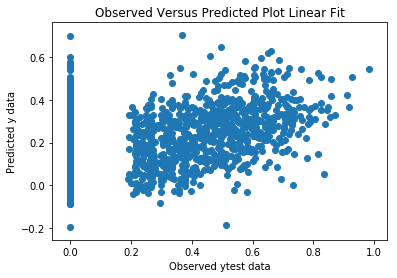

In [10]:
model = LinearRegression()
model.fit(Xtrain, ytrain)
intercept =model.intercept_
coefs = model.coef_
preds = model.predict(Xtest)
plt.scatter(ytest, preds)
plt.xlabel('Observed ytest data')
plt.ylabel('Predicted y data')
plt.title('Observed Versus Predicted Plot Linear Fit')
plt.show()

In [11]:
print("R-squared for test set:", model.score(Xtest, ytest))
print("R-squared for the training set:", model.score(Xtrain, ytrain))

R-squared for test set: 0.1809106777522248
R-squared for the training set: 0.2907378428507523


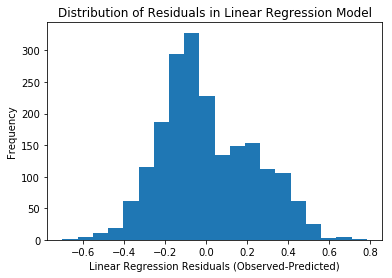

In [12]:
plt.hist(x=(ytest-preds), bins=20)
plt.xlabel("Linear Regression Residuals (Observed-Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals in Linear Regression Model")
plt.show()

Here it is shown that the residuals of the linear regression are mostly normally distributed, with a slight right skew. If it were more significantly right skewed, a Box-Cox Transformation may have been an appropriate step to normalize the residuals, but one will not be done here. 

In [13]:
 print(len(coefs))
equation_coefs = pd.Series(coefs)
equation_coefs

489


0     -0.169245
1      0.000835
2      0.010049
3      0.001898
4     -0.002134
5     -0.123762
6     -0.118620
7     -0.000051
8     -0.060962
9      0.084559
10     0.161074
11     0.042933
12    -0.307037
13     0.144190
14    -0.045561
15     0.203075
16    -0.289080
17     0.251506
18     0.122428
19    -0.162181
20     0.040646
21    -0.092270
22    -0.133514
23     0.231454
24    -0.184884
25     0.014379
26    -0.027738
27     0.065913
28    -0.102934
29    -0.024216
         ...   
459   -0.149972
460   -0.120736
461   -0.136470
462   -0.039701
463   -0.056147
464   -0.046511
465   -0.596594
466   -0.583565
467   -0.609219
468   -0.601099
469   -0.587956
470   -0.603558
471   -0.593587
472   -0.583544
473   -0.610546
474   -0.583579
475   -0.585817
476   -0.577142
477    0.004116
478   -3.555124
479   -3.561134
480    0.002130
481    4.119005
482   -0.001956
483    0.000058
484    0.003195
485    0.011397
486    0.021456
487    0.020703
488    0.008254
Length: 489, dtype: floa

In [14]:
intercept

0.19340794901212502

The two cells above would potentially give the linear equation for the prediction line in the regression. The equation would be formatted in the form:


\begin{equation}
{
'song hotness' = 0.1934  -0.1692x_1 -0.0008x_2 + 0.0101x_3+ ...
}
\end{equation}


The full equation has 489 terms including the intercept.

### Cross Validation

There are some limitations to using a training/testing split because testing accuracy has the potential to have high variance based on what observations we group into the training and testing sets. Cross validation will help test different sets of observations as our testing sets. 

In [15]:
cv_scores = cross_val_score(model, X_vec, y, cv = 5, scoring = "r2")
print(cv_scores)

[ 0.20913997  0.21209861  0.1896201  -9.0318123   0.18892909]


The 5 above values are R-squared values which reveal the general range of R-squared values the regression was recieving. The negative value in this set that is an outlier represents a fold of our training set which performed worse than a horizontal line. 

Because of these values it may be better to start fitting polynomial regressions to the data. 

If we remember from the tidying of the data, missing values for "song_hotness" were replaced with 0's because they were not popular enoug for the data collection program assessing song popularity to pick them up. The plot of observed versus predicted for the linear regression above has a long string of these observed 0's for the true song_hotness value, and the regression performs rather poorly because of this. 

For this reason, the block below creates a new subset of the data where there are no observations of "song_hotness" as 0.

In [16]:
df_sub = df.loc[df.song_hotness != 0]
X_sub = df_sub[['artist_hotness', 'bars_start', 'beats_start', 'duration', 'end_of_fade_in', 'genre', 'key', 'loudness', 'mode', 'release_year', 'start_of_fade_out', 'tempo', 'time_signature']]
X_sub = X_sub.fillna( 'NA' )
y_sub = df_sub['song_hotness']
X_sub_dict = X_sub.to_dict(orient = 'records')
vec_ = DictVectorizer(sparse = True, dtype = int)
X_sub_vec = vec_.fit_transform(X_sub_dict)
Xtrain_, Xtest_, ytrain_, ytest_ = train_test_split(X_sub_vec, y_sub, test_size=0.2, random_state = 10)

In [17]:
len(df_sub)

4214

The data is now left with 4,214 observations, so this is an unfortunate trade off, but it was made in hopes of making a model with a greater R-squared value on the testing data because the model needs to perform well on data that it has not seen before. 

### Re-run Linear Regression on Subsetted Data: Model 2

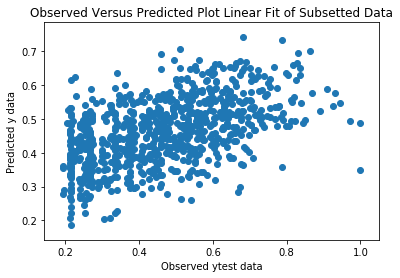

In [18]:
new_model = LinearRegression()
new_model.fit(Xtrain_, ytrain_)
new_intercept =new_model.intercept_
new_coefs = new_model.coef_
new_preds = new_model.predict(Xtest_)
plt.scatter(ytest_, new_preds)
plt.xlabel('Observed ytest data')
plt.ylabel('Predicted y data')
plt.title('Observed Versus Predicted Plot Linear Fit of Subsetted Data')
plt.show()

In [19]:
print("R-squared for test set:", new_model.score(Xtest_, ytest_))
print("R-squared for the training set:", new_model.score(Xtrain_, ytrain_))

R-squared for test set: 0.2603438010028556
R-squared for the training set: 0.3547628574185437


The new_model has a slightly improved R-squared for the both the training and testing sets. As stated before there is more importance placed on the testing set because the model needs to be able to successfully predict the target based off of data that it has not seen before. It should be considered a success to see the test set R-squared value increase from what was seen in the first regression model.

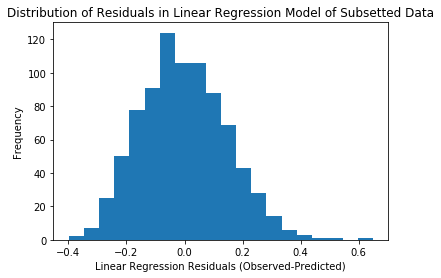

In [20]:
plt.hist(x=(ytest_-new_preds), bins=20)
plt.xlabel("Linear Regression Residuals (Observed-Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals in Linear Regression Model of Subsetted Data")
plt.show()

The improved performance of the model comes with normally distributed residuals, so this is a good sign for the model.

In [21]:
cv_scores = cross_val_score(new_model, X_sub_vec, y_sub, cv = 5, scoring = "r2")
print(cv_scores)

[0.18500751 0.22571101 0.23480081 0.20212329 0.22588045]


Now when cross fold validation is run there is improvement as each fold has the model performing better than a horizontal line prediction.

### Fitting Polynomial Regression: Model 3

In an attempt to attain a better fit model, we will try to fit a polynomial regression to the subsetted data and see what kind of fit we get. 

In [22]:
poly = PolynomialFeatures(degree = 2)
X_train_quad = poly.fit_transform(Xtrain_.toarray())

In [23]:
X_test_quad = poly.fit_transform(Xtest_.toarray())

In [24]:
###THIS TAKES ABOUT 5 MINS TO RUN
lin_reg = LinearRegression()
lin_reg.fit(X_train_quad, ytrain_)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
y_preds = lin_reg.predict(X_test_quad)

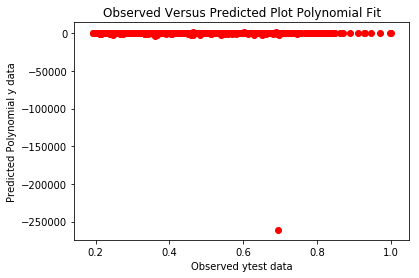

843
843


In [26]:
plt.scatter(ytest_, y_preds, color='red')
plt.xlabel('Observed ytest data')
plt.ylabel('Predicted Polynomial y data')
plt.title('Observed Versus Predicted Plot Polynomial Fit')
plt.show()
print(len(y_preds))
print(len(ytest_))

In [27]:
print("R-squared for test set:", lin_reg.score(X_test_quad, ytest_))
print("R-squared for the training set:", lin_reg.score(X_train_quad, ytrain_))

R-squared for test set: -2728996278.152925
R-squared for the training set: 0.8945864351069066


The model seems to perform extremely poor on the test set, but there is clearly a major outlier. The block below plots the polynomial regression without that huge outlier.

### Rerunning Polynomial Regression Without Outlier: Model 4

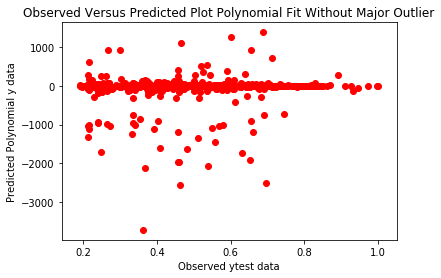

In [28]:
i = np.where(y_preds < -100000)
y_preds_sub = np.delete(y_preds, i)
ytest_matrix = ytest_.as_matrix()
ytest_sub = np.delete(ytest_matrix, i)
plt.scatter(ytest_sub, y_preds_sub, color='red')
plt.xlabel('Observed ytest data')
plt.ylabel('Predicted Polynomial y data')
plt.title('Observed Versus Predicted Plot Polynomial Fit Without Major Outlier')
plt.show()

Even when the most extreme outlier, the plot performs quite poorly and predicts many impossible negative values. For this reason, the polynomial regression performs worse than the linear fit.

### Implementing a Support Vector Regression To Predict Song Popularity: Model 5

Using an SVR on the music data could potentially enable more effective machine learning in predicting the 'song_hotness' target variable. This model can use Support Vector Machines on the training data by running a linear regression in an infinite dimensional space. The important factor in SVR is the kernal which determines the form of the regression, and in the SVR run below, a Gaussian kernal is chosen. The kernal will help determine which feature columns are most influencial in the data, and this is then accounted for to attain a best fit of prediction values with minimal loss.

In [29]:
svr = SVR(kernel = 'rbf')
svr.fit(Xtrain_, ytrain_)
svr_preds = svr.predict(Xtest_)

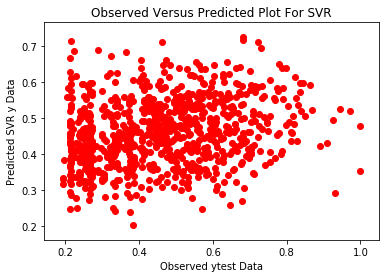

In [30]:
plt.scatter(ytest_, svr_preds, color='red')
plt.xlabel('Observed ytest Data')
plt.ylabel('Predicted SVR y Data')
plt.title('Observed Versus Predicted Plot For SVR')
plt.show()

In [31]:
print("R-squared for test set:", svr.score(Xtest_, ytest_))
print("R-squared for the training set:", svr.score(Xtrain_, ytrain_))

R-squared for test set: -0.0307727036584311
R-squared for the training set: 0.5766814820810404


The R-squared value for the test set here does not perform well at all, very close to being only as good as a horizontal line.

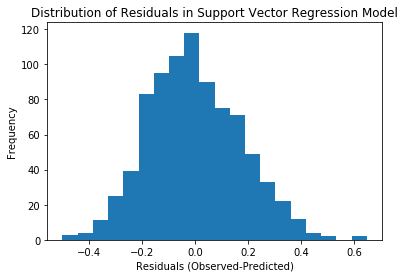

In [32]:
plt.hist(x=(ytest_-svr_preds), bins=20)
plt.xlabel("Residuals (Observed-Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals in Support Vector Regression Model")
plt.show()

Here the residuals are reasonably normally distributed for the SVR model.

In [33]:
cv_scores = cross_val_score(svr, X_sub_vec, y_sub, cv = 5, scoring = "r2")
print(cv_scores)

[-0.08876588 -0.0491331   0.03804751 -0.00037512 -0.02946559]


The cross validations show that the R-squared values all perform about equally poor, and this validates that something about the model is underperforming. In an effort to improve these values we will do another train test split and test the data against a larger selection of test data to compare its performance.

### Rerunning SVR with Different Split Value: Model 6

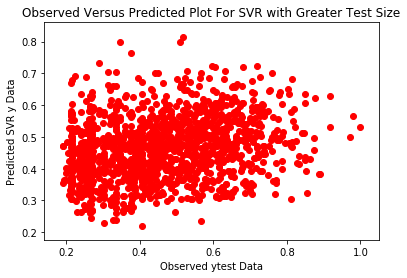

In [38]:
Xtrain_n, Xtest_n, ytrain_n, ytest_n = train_test_split(X_sub_vec, y_sub, test_size=0.33, random_state = 21)
svr_new = SVR(kernel = 'rbf')
svr_new.fit(Xtrain_n, ytrain_n)
svr_preds_new = svr_new.predict(Xtest_n)
plt.scatter(ytest_n, svr_preds_new, color='red')
plt.xlabel('Observed ytest Data')
plt.ylabel('Predicted SVR y Data')
plt.title('Observed Versus Predicted Plot For SVR with Greater Test Size')
plt.show()

In [39]:
print("R-squared for test set:", svr.score(Xtest_n, ytest_n))
print("R-squared for the training set:", svr.score(Xtrain_n, ytrain_n))

R-squared for test set: 0.4290203800602656
R-squared for the training set: 0.45882894357030674


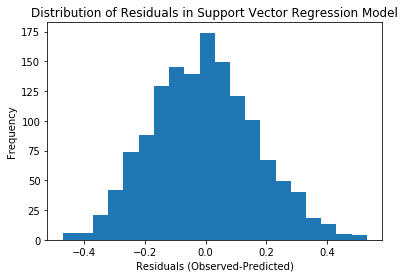

In [40]:
plt.hist(x=(ytest_n-svr_preds_new), bins=20)
plt.xlabel("Residuals (Observed-Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals in Support Vector Regression Model")
plt.show()

Residuals are normally distributed.

In [41]:
cv_scores = cross_val_score(svr_new, X_sub_vec, y_sub, cv = 3, scoring = "r2")
print(cv_scores)

[-0.09260186 -0.03952808 -0.03672965]


Despite the higher R-squared in the model, failure of the cross validation reveals that we are likely overfitting with this more complex SVR model, and it is not appropriate here.


Compiled conclusions are included in the 06-Conclusions notebook.